In [1]:
from bs4 import BeautifulSoup
import requests
import os
from abc import ABC
from PyPDF2 import PdfFileReader, PdfFileWriter
from whoosh import index
from whoosh.index import create_in
from whoosh.fields import Schema, TEXT, ID
import sys
from whoosh.qparser import QueryParser
from whoosh import scoring
from whoosh.index import open_dir
from whoosh.analysis import StandardAnalyzer
import csv
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#abstract class (do not instantiate)
class Searchable:
    
    def __init__(self, root, index):
        
        self.root = root
        self.index = index
    
    #provides a full text search of all pdfs over the root
    def fullTextSearch(self, terms, reindex):
        
        if(reindex):
            self.createSearchableData()
        
        self.phrases = terms
        r = []
    
        for i in range(len(self.phrases)):
            r.append(self.termQuery(self.phrases[i]))
        
        return r
    
    
    #helper, creates a searchable index
    def createSearchableData(self):  
        
        schema = Schema(title=TEXT(stored=True),path=ID(stored=True), content=TEXT(phrase=True, analyzer=StandardAnalyzer(stoplist=None)))
        if not os.path.exists("indexdir"):
            os.mkdir("indexdir")

        ix = index.create_in("indexdir", schema, indexname = self.index)
        writer = ix.writer()

        filepaths = [os.path.join(self.root,i) for i in os.listdir(self.root)]
        for path in filepaths:
            text = self.getPDFText(path)
            text2 = self.getPDFText2(path)

            for i in range(len(text)):
                writer.add_document(title=path.split("\\")[1] + '_Page_' + str(i), path=path,\
                    content=text[i])
                writer.add_document(title=path.split("\\")[1] + '_Page_' + str(i) + '_2', path=path,\
                    content=text2[i])
            print(path.split("\\")[1] + ' has been indexed')
        writer.commit()            

        
    
    #helper, searches index for particular phrase and prints results
    def termQuery(self, phrase):

        ix = open_dir("indexdir", indexname = self.index)
 
        qp = QueryParser("content", schema=ix.schema)
        q = qp.parse(phrase)
    
        res = []
    
        with ix.searcher() as s:
            results = s.search(q, limit=None)
            for result in results:
                res.append(str(result))
            return res
        
    #static helper, returns text found in pdf
    def getPDFText(self, path):
        text = []
        
        with open(path, 'rb') as f:
            pdf = PdfFileReader(f)
            numPages = pdf.getNumPages()
            for pageNum in range(numPages):
                page = pdf.getPage(pageNum)
                
                #reads in specific page of doc
                try:
                    text.append(page.extractText().replace('\n', ' '))
                except TypeError:
                    print('TypeError in ' + path)

        return text
    
    def getPDFText2(self, path):
        text = []
        
        with open(path, 'rb') as f:
            pdf = PdfFileReader(f)
            numPages = pdf.getNumPages()
            for pageNum in range(numPages):
                page = pdf.getPage(pageNum)
                
                #reads in specific page of doc
                try:
                    text.append(page.extractText().replace('\n', ''))
                except TypeError:
                    print('TypeError in ' + path)

        return text

    #static, call to compile pdf with array of results
    def compileResults(self, path, phrases, results):
        if not os.path.exists(path):
            os.makedirs(path)
        
        for i in range(len(phrases)):
            output = PdfFileWriter()
        
            docs = set([])
            
            #go through all results, 3 = path, 7 = pdf and page num
            for result in results[i]:
                data = result.split('\'')
                
                pdfName = data[3]
                pageNum = data[7][len(data[3][11:]) + 6:]
                
                if '_' in pageNum:
                    pageNum = pageNum[0: len(pageNum)-2]
                
                pdf = pdfName + pageNum
                
                length = len(docs)
                docs.add(pdf)
                if length != len(docs):
                   
                    with open(data[3], 'rb') as f:
                        pdf = PdfFileReader(f)              
                        output.addPage(pdf.getPage(int(pageNum)))
                        
                        name = phrases[i].replace('"', '')

                        with open(path +'\\' + name + '.pdf', 'wb') as outputStream:
                            output.write(outputStream)
                    
    def printResults(self, phrases, results):
        
        for i in range(len(results)):
            print(phrases[i] + ':')
        
            for element in results[i]:
                print(element)
                print(element[21:29])
    


#searches through pma database; can call fullTextSearch and deleteFiles
class PSearch(Searchable):
    
    def __init__(self, r, i):
        super().__init__(r, i)
        self.committee = ''
       
        if not os.path.exists(self.root):
            os.mkdir(self.root)
        
        
    #download SSEDs from a start date to an end date (downloads to root directory)
    def downloadSSEDs(s, e):
        
        print('hello1')
        
        for i in range(s.monthsInBetween(e)):
            self.getSummaries(self.getPMAS(s.getDate(), s.lastDay()))
            s.nextMonth()
        
        self.getSummaries(self.getPMAS(e.firstDay(), e.getDate()))
    
    #deletes all files that were downloaded (use after performing full text searches)    
    def deleteFiles(self):
        filepaths = [os.path.join(self.root,i) for i in os.listdir(self.root)]
        for path in filepaths:
            os.remove(path)
        
    #helper, returns url of pma summary pdf and determines if pma has summary
    def getSummary(self, URL):

        page_response = requests.get(URL, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")

        textContent = page_content.find_all(style="text-decoration:underline;")

        #checks if original pma contains a summary
        for element in textContent:
            if(element.text == 'Summary of Safety and Effectiveness'):
                
                
                if int(URL[69:71]) <= 1:
                    return 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + '/' + URL[68:75] + 'B.pdf'
                
                if int(URL[69:71]) >= 70:
                    return 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + '/' + URL[68:75] + 'B.pdf'
                
                #if the pma version is less than 10 the url is formatted a little different
                elif int(URL[69:71]) < 10:
                    return 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + URL[70:71] + '/' + URL[68:75] + 'B.pdf'
                
                return 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + URL[69:71] + '/' + URL[68:75] + 'B.pdf'

        return URL[68:75] + ' does not contain a Summary of Safety and Effectiveness' 

    #helper, gets the url of pmas given a range of time
    def getPMAS(self, f, t):
        return 'https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfPMA/pma.cfm?start_search=1&applicant=&tradename=&productcode=&pmanumber=&supplementnumber=&advisorycommittee=' + self.committee + '&docketnumber=&supplementtype=&expeditedreview=&center=D&ivdproducts=off&combinationproducts=off&decisiondatefrom=' + formatDate(f) + '&decisiondateto=' + formatDate(t) +'&noticedatefrom=&noticedateto=&znumber=&pagenum=500'
    
    #helper, downloads all pma summary pdfs in the url
    def getSummaries(self, url):

        startUrl = 'https://www.accessdata.fda.gov'

        page_response = requests.get(url, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")

        textContent = page_content.find_all(style="text-decoration:underline;")

        #looks through all pmas in url
        for element in textContent:
            string = str(element)
            deviceURL = startUrl + string[9: 9 + string[9:len(string)].index('\"')]

            #if the pma is original
            if len(deviceURL) == 75:

                file_url = self.getSummary(deviceURL)
                
                #if the pma does not have a summary
                if(len(file_url) == 62):
                    print(file_url)
                else:
                    r = requests.get(file_url, stream = True) 
                    
                    start = len(file_url) - 12
                    
                    #download pmas into Summaries folder
                    with open(self.root + '/' + file_url[start:59],"wb") as pdf: 
                        for chunk in r.iter_content(chunk_size=1024): 
                            if chunk: 
                                pdf.write(chunk)
                                
    def total(self, results):

        unique = set([])

        for i in range(len(results)):

            for element in results[i]:
                unique.add(element.split('\'')[3])

        return str(len(unique))
    
    def resultValues(self, phrases, results):
         
        for i in range(len(results)):
            
            unique = set([])
            
            for element in results[i]:
                unique.add(element.split('\'')[3])
                
            print(phrases[i] + ': ' + str(len(unique)))
    
    def getSets(self, results):
        
        toRet = []
        
        for i in range(len(results)):

            unique = set([])

            for element in results[i]:
                unique.add(element.split('\'')[3].split('\\\\')[1].split('.')[0].split('B')[0])

            toRet.append(unique)
        
        return toRet
    
    def writeSpreadsheets(self, root, phrases, results):
        
        res = self.getSets(results)
        
        for i in range(len(res)):
            
            name = phrases[i].replace('"', '')
            if len(res[i]) != 0:
                pmaInfoList(root, name, res[i])
    
    def getTotalSpreadsheet(self, root, results):
        
        unique = set([])
        
        for i in range(len(results)):
            
            for element in results[i]:
                unique.add(element.split('\'')[3].split('\\\\')[1].split('.')[0].split('B')[0])
        
        if len(unique) != 0:
            pmaInfoList(root, 'total', unique)
            
    def plotTotal(self, root):
        with open(root + '\\total.csv') as file:
            string = file.read().replace('\n\n','\n')
            lines = string.splitlines()
    
        values = [0] * 18

        for line in lines:
            values[int(line[14:18])-2002] += 1
        plt.bar(range(0,18), values)
        #plt.axis([0,17,0,30])
        plt.show()
        
    def plotTotalTwo(self, root, word):

        with open('advisorycommittees.txt', 'r') as file:
            advisoryCommittees = file.read().splitlines()

        with open(root + '\\total.csv') as file:
            string = file.read().replace('\n\n','\n')
            lines = string.splitlines()

        arrays = {}

        for ac in advisoryCommittees:
            arrays[ac] = [0] * 18

        for line in lines:
            arrays[line.split(',')[2]][int(line[14:18])-2002] += 1

        ind = np.arange(18)    # the x locations for the groups
        width = .35     # the width of the bars: can also be len(x) sequence

        p = []
        committees = getKeys(arrays)
        p.append(plt.bar(ind, arrays[committees[0]], width))
        p.append(plt.bar(ind, arrays[committees[1]], width, bottom = arrays[committees[0]]))
        bars = np.add(arrays[committees[0]], [0] * 18).tolist()

        for i in range(2, len(committees)):
            bars = np.add(arrays[committees[i-1]], bars).tolist()
            p.append(plt.bar(ind, arrays[committees[i]], width, bottom = bars))

        pLegend = []
        cLegend = []

        for ps in p:
            pLegend.append(ps[0])

        for c in committees:
            cLegend.append(c)

        plt.ylabel('Number of Unique SSEDs')
        plt.xlabel('Year')
        plt.title('Number of Unique SSEDs that contain: ' + word)
        plt.xticks(ind, range(2002, 2020), rotation='vertical')
        plt.legend(pLegend, cLegend, bbox_to_anchor=(1,1.05))

        plt.show()

def getKeys(dictionary):

    l = []

    for k,v in dictionary.items():
        l.append(k)

    return l

class KSearch(Searchable):
        
    def __init__(self, s, e, r, i):
        
        super().__init__(r,i)
        self.start = s
        self.end = e

        if not os.path.exists(self.root):
            os.mkdir(self.root)

        for i in range(self.start.monthsInBetween(self.end)):
            self.loadDatabase(self.start.getDate(), self.start.lastDay())
            self.start.nextMonth()

        self.loadDatabase(self.end.firstDay(), self.end.getDate())
            
    def getSumURL(self, kURL):
        page_response = requests.get(kURL, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        textContent = page_content.find_all(style = 'text-decoration:underline;')
        for i in range(len(textContent)):

            if ('summary' in str(textContent[i])):
                ID = kURL.split('ID=')[1]

                year = int(ID[1:3])

                if year > 10:
                    return 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + ID[1:3] + '/'+ ID + '.pdf'
                elif year > 1:
                    return 'http://www.accessdata.fda.gov/cdrh_docs/pdf' + ID[2:3] + '/'+ ID + '.pdf'
                else: 
                    return 'http://www.accessdata.fda.gov/cdrh_docs/pdf/'+ ID + '.pdf'
        return 'no summary found'


    #given the URL of a 510K summary, download it as a PDF
    def download510K(self, sURL):
        r = requests.get(sURL, stream = True) 

        #download pmas into Summaries folder
        with open(self.root + '/' + sURL.split('/')[5],"wb") as pdf: 
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: 
                    pdf.write(chunk)
    
    def catchTimeout(self, detailsURL):
        try:
            sumURL = self.getSumURL(detailsURL)

            if sumURL != 'no summary found':
                self.download510K(sumURL)
                print('Successfully downloaded ' + detailsURL)
                
        except:
            print('ReadTimeout: ' + detailsURL)
            self.catchTimeout(detailsURL)
    
    def loadDatabase(self, start, end):
        url = 'https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpmn/pmn.cfm?start_search=1&Center=&Panel=&ProductCode=&KNumber=&Applicant=&DeviceName=&Type=&ThirdPartyReviewed=&ClinicalTrials=&Decision=&DecisionDateFrom=' + start+'&DecisionDateTo='+ end+'&IVDProducts=&Redact510K=&CombinationProducts=&ZNumber=&PAGENUM=500'
        page_response = requests.get(url, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        textContent = page_content.find_all(style = 'text-decoration:underline;')

        for i in range(2, len(textContent)):
            if i%2 == 0:
                detailsURL = 'https://www.accessdata.fda.gov' + str(textContent[i]).split('"')[1]
                
                self.catchTimeout(detailsURL)
                
                    
                    
            
                                
#creates an object to be searched from already existing pdfs; can call fullTextSearch                                
class RootSearch(Searchable):
    
    def __init__(self, r, i):
        super().__init__(r, i)
                                
#date helper class
class Date:
    
    daysInMonth = [[0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31], [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]]
    
    
    def __init__(self, month, day, year):
        self.m = month
        self.d = day
        self.y = year
    
    def getDate(self):
        
        if(len(str(self.m)) > 1):
            toReturn = str(self.m)
        else:
            toReturn = '0' + str(self.m)
            
        if(len(str(self.d)) > 1):
            toReturn += '/' + str(self.d)
        else:
            toReturn += '/0' + str(self.d)
            
        toReturn += '/' + str(self.y)
        
        return toReturn
    def nextMonth(self):
        if(self.m == 12):
            self.m = 1
            self.y += 1
        else:
            self.m +=1
        self.d = 1
            
    def prevMonth(self):
        if(self.m == 1):
            self.m = 12
            self.y -= 1
        else:
            self.m -= 1
        self.d = 1
    
    def lastDay(self):
        
        if self.m < 10:
            toReturn = '0' + str(self.m)
        else:
            toReturn = str(self.m)
        
        return toReturn + '/' + str(self.daysInMonth[self.y%4][self.m]) + '/' + str(self.y)
    
    def firstDay(self):
          
        if self.m < 10:
            toReturn = '0' + str(self.m)
        else:
            toReturn = str(self.m)
        
        return toReturn + '/01/' + str(self.y)
    
    def monthsInBetween(self, other):
        return (other.y - self.y)*12 + (other.m - self.m)
    
#01%2F01%2F2017 
def formatDate(date):
    return date[0:2] + '%2F' +date[3:5] + '%2F' + date[6:]
        
    
def readInTerms(file):
    with open(file, 'r', encoding = 'utf-8') as f:
        words = f.read()

    wordList = words.splitlines()
    
    toRet = []
    
    for word in wordList:
        if ' ' in word:
            toRet.append('"' + word + '"')
        else:
            toRet.append(word)
            
    return toRet

def getInfo(ID, lines):
    url = 'https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpma/pma.cfm?id=' + ID
    page_response = requests.get(url, timeout=5)
    page_content = BeautifulSoup(page_response.content, "html.parser")

    first = 'none'
    second = 'none'
    
    textContent = page_content.find_all('tr')
    
    for i in range(9, len(textContent)):
        if 'Decision Date' in str(textContent[i]):
            first = str(textContent[i]).split('<td align="Left">')[1][0:10]
        elif 'Advisory Committee' in str(textContent[i]):
            second = str(textContent[i]).split('<td align="Left">')[1].split('</td>')[0]
    lines.append([ID, first, second])
    return lines
def writeToCSV(root, lines, file):
    
    with open(root + '\\' + file + '.csv', 'w') as csvfile:
        filewriter = csv.writer(csvfile)
        filewriter.writerows(lines)

def pmaInfoDir(path):
    filepaths = [os.path.join(path,i) for i in os.listdir(path)]
    lines = []
    
    for file in filepaths:
        lines = getInfo(file.split('\\')[1][0:7], lines)
    
    writeToCSV(lines)
    
def pmaInfoList(root, phrase, names):
    lines = []
    
    for name in names:
        lines = getInfo(name, lines)
        
    writeToCSV(root, lines, phrase)

#search = PSearch(Date(1,1,2018), Date(7,29,2019), 'all', 'Summaries', 'test1')
#search = KSearch(Date(8,1,2017), Date(7,29,2019), 'KSummaries', 'KSums')

Text(value='')

computer: 86


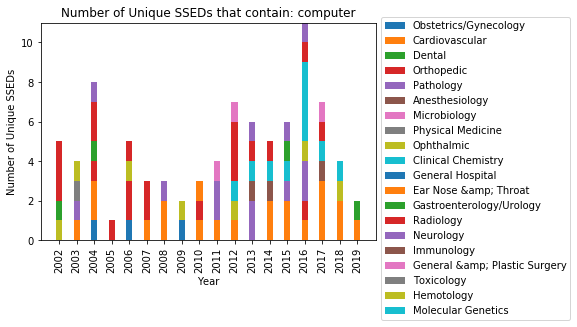

In [2]:
from ipywidgets import widgets
from IPython.display import display
from IPython.core.display import HTML

outputText = widgets.Text()
inputText = widgets.Text()
def sendIn(sender):
    search = PSearch('Summaries', 'test1')
    results = search.fullTextSearch([inputText.value], False)
    search.resultValues([inputText.value], results)
    search.getTotalSpreadsheet('Location', results)
    search.plotTotalTwo('Location', str(inputText.value))

display(HTML('<h1 style=\'margin-top:400px\'>SimSight</h1'))
display(HTML('<h2>created by Mitchell Fanger</h2>'))
display(HTML('<h4>SimSight is a tool used to perform full text searches on directories of PDF\'s</h4'))
display(HTML('<h4>Search the public SSED database for a keyword and plot its frequency versus approval date</h4>'))
display(HTML('<h4>Enter keyword:</h4>'))

inputText.on_submit(sendIn)

inputText


<h1 style='margin-top:400px'></h1>